# 1. 初めに

本ソースコードは[R Guide for TMLE in Medical Research](https://ehsanx.github.io/TMLEworkshop/)の第６章に基づいており\
TMLEの手順の整理を行うことが目的である

# 2. 使用データ

詳細は[第１章](https://ehsanx.github.io/TMLEworkshop/rhc-data-description.html)を参照\
RHC（新機能を測定する装置）の使用時間に関するデータである

## 2.1データの読み込み

In [10]:
#データのダウンロード
ObsData <- read.csv("https://hbiostat.org/data/repo/rhc.csv", header = TRUE)

## 2.2データの抽出,前処理

1.2 分析データ　に沿ってデータの抽出を行う（詳細は省略）

In [14]:
# add column for outcome Y: length of stay 
# Y = date of discharge - study admission date
# Y = date of death - study admission date if date of discharge not available
ObsData$Y <- ObsData$dschdte - ObsData$sadmdte
ObsData$Y[is.na(ObsData$Y)] <- ObsData$dthdte[is.na(ObsData$Y)] - 
  ObsData$sadmdte[is.na(ObsData$Y)]
# remove outcomes we are not examining in this example
ObsData <- dplyr::select(ObsData, 
                         !c(dthdte, lstctdte, dschdte, death, t3d30, dth30, surv2md1))
# remove unnecessary and problematic variables 
ObsData <- dplyr::select(ObsData, 
                         !c(sadmdte, ptid, X, adld3p, urin1, cat2))

# convert all categorical variables to factors 
factors <- c("cat1", "ca", "cardiohx", "chfhx", "dementhx", "psychhx", 
             "chrpulhx", "renalhx", "liverhx", "gibledhx", "malighx", 
             "immunhx", "transhx", "amihx", "sex", "dnr1", "ninsclas", 
             "resp", "card", "neuro", "gastr", "renal", "meta", "hema", 
             "seps", "trauma", "ortho", "race", "income")
ObsData[factors] <- lapply(ObsData[factors], as.factor)
# convert our treatment A (RHC vs. No RHC) to a binary variable
ObsData$A <- ifelse(ObsData$swang1 == "RHC", 1, 0)
ObsData <- dplyr::select(ObsData, !swang1)
# Categorize the variables to match with the original paper
ObsData$age <- cut(ObsData$age,breaks=c(-Inf, 50, 60, 70, 80, Inf),right=FALSE)
ObsData$race <- factor(ObsData$race, levels=c("white","black","other"))
ObsData$sex <- as.factor(ObsData$sex)
ObsData$sex <- relevel(ObsData$sex, ref = "Male")
ObsData$cat1 <- as.factor(ObsData$cat1)
levels(ObsData$cat1) <- c("ARF","CHF","Other","Other","Other",
                          "Other","Other","MOSF","MOSF")
ObsData$ca <- as.factor(ObsData$ca)
levels(ObsData$ca) <- c("Metastatic","None","Localized (Yes)")
ObsData$ca <- factor(ObsData$ca, levels=c("None",
                                          "Localized (Yes)","Metastatic"))
# Rename variables
names(ObsData) <- c("Disease.category", "Cancer", "Cardiovascular", 
                    "Congestive.HF", "Dementia", "Psychiatric", "Pulmonary", 
                    "Renal", "Hepatic", "GI.Bleed", "Tumor", 
                    "Immunosupperssion", "Transfer.hx", "MI", "age", "sex", 
                    "edu", "DASIndex", "APACHE.score", "Glasgow.Coma.Score", 
                    "blood.pressure", "WBC", "Heart.rate", "Respiratory.rate", 
                    "Temperature", "PaO2vs.FIO2", "Albumin", "Hematocrit", 
                    "Bilirubin", "Creatinine", "Sodium", "Potassium", "PaCo2", 
                    "PH", "Weight", "DNR.status", "Medical.insurance", 
                    "Respiratory.Diag", "Cardiovascular.Diag", 
                    "Neurological.Diag", "Gastrointestinal.Diag", "Renal.Diag",
                    "Metabolic.Diag", "Hematologic.Diag", "Sepsis.Diag", 
                    "Trauma.Diag", "Orthopedic.Diag", "race", "income", 
                    "Y", "A")


#ObsDataの保存先を指定
dir = './data/rhcAnalytic.RDS'
saveRDS(ObsData, file = dir)

# 3. TMLEの実装

## STEP1 データの正規化

アウトカム$Y$を正規化する（推奨されたからやっているが理由はわかってない）\
Gruber, Susan, and Mark J van der Laan. 2010. “A Targeted Maximum Likelihood Estimator of a Causal Effect on a Bounded Continuous Outcome.” The International Journal of Biostatistics 6
で述べられている（らしい）

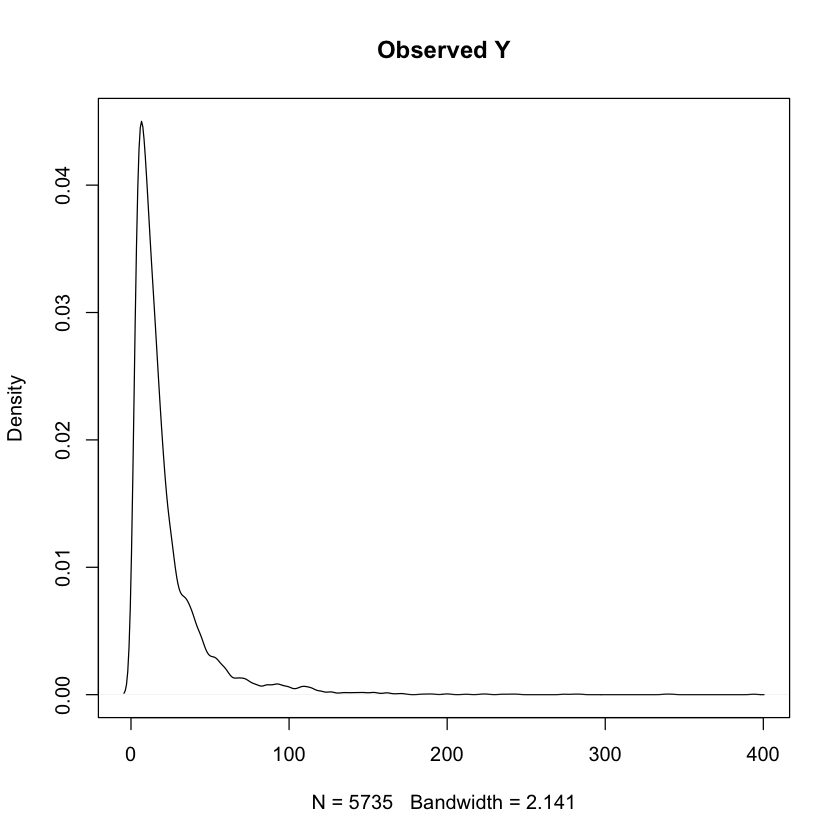

In [15]:
plot(density(ObsData$Y), main = "Observed Y")

In [16]:
# [0,1]に収まるように正規化
min.Y <- min(ObsData$Y)
max.Y <- max(ObsData$Y)
ObsData$Y.bounded <- (ObsData$Y-min.Y)/(max.Y-min.Y)

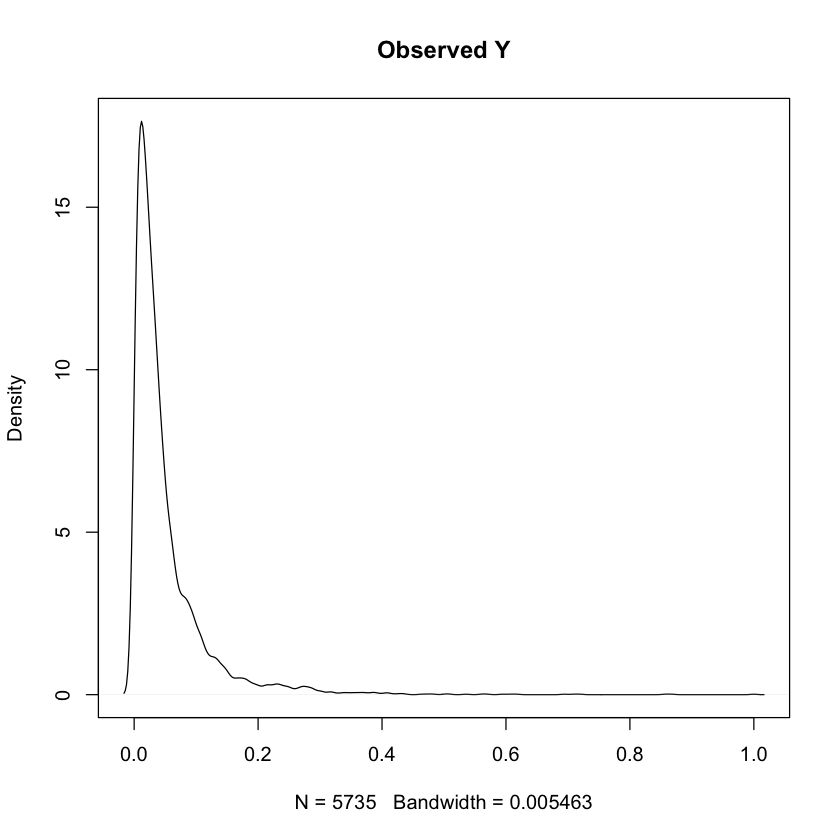

In [17]:
plot(density(ObsData$Y.bounded), main = "Observed Y")

## STEP2  $E[Y |X=x,C=c]=Q(x,c)$の推定

ここで求める初期推定量の推定にSuper learnerを用いる.まずはモデルへの入力

In [18]:
library(SuperLearner)
set.seed(123)
ObsData.noY <- dplyr::select(ObsData, !c(Y,Y.bounded))
Y.fit.sl <- SuperLearner(Y=ObsData$Y.bounded, 
                       X=ObsData.noY, 
                       cvControl = list(V = 3),
                       SL.library=c("SL.glm", 
                                    "SL.glmnet", 
                                    "SL.xgboost"),
                       method="method.CC_nloglik", 
                       family="gaussian")

 要求されたパッケージ nnls をロード中です 

 要求されたパッケージ gam をロード中です 

 要求されたパッケージ splines をロード中です 

 要求されたパッケージ foreach をロード中です 

Loaded gam 1.20.2


Super Learner

Version: 2.0-28

Package created on 2021-05-04


 要求されたパッケージ nloptr をロード中です 

 要求されたパッケージ glmnet をロード中です 

 要求されたパッケージ xgboost をロード中です 



訓練したデータセットに対して予測値を取得

In [21]:
ObsData$init.Pred <- predict(Y.fit.sl, newdata = ObsData.noY, 
                           type = "response")$pred

初期推定値 $\hat{Q^0}(x,c)$を求める(添字nはいらない？)

In [23]:
ObsData.noY$A <- 1
ObsData$Pred.Y1 <- predict(Y.fit.sl, newdata = ObsData.noY, 
                           type = "response")$pred

ObsData.noY$A <- 0
ObsData$Pred.Y0 <- predict(Y.fit.sl, newdata = ObsData.noY, 
                           type = "response")$pred

これらの差で初期のATTを計算

In [24]:
ObsData$Pred.TE <- ObsData$Pred.Y1 - ObsData$Pred.Y0   

## STEP3 傾向スコア$P(X=1|C=c)=\pi(c)$の推定

STEP２と同様にSuper learnerを用いて推定を行う

In [25]:
set.seed(124)
ObsData.noYA <- dplyr::select(ObsData, !c(Y,Y.bounded,
                                          A,init.Pred,
                                          Pred.Y1,Pred.Y0,
                                          Pred.TE))
PS.fit.SL <- SuperLearner(Y=ObsData$A, 
                       X=ObsData.noYA, 
                       cvControl = list(V = 3),
                       SL.library=c("SL.glm", 
                                    "SL.glmnet", 
                                    "SL.xgboost"),
                       method="method.CC_nloglik",
                       family="binomial")  

all.pred <- predict(PS.fit.SL, type = "response")
ObsData$PS.SL <- all.pred$pred 

最終行で求めたものが予測値$\hat{\pi}(C_i)$である

## STEP4  初期推定量$\hat{Q^0}(x,c)$の更新

STEP１で求めた$\hat{Q^0}(x,c)$を更新する.更新式は以下


$$\hat{Q^*}(x,c) = expit(logit(\hat{Q^0}(x,c))+\varepsilon_1 \frac{x}{\hat{\pi}(c)}+\varepsilon_2 \frac{1-x}{1-\hat{\pi}(c)})$$


まず$\varepsilon_1と\varepsilon_2$を最尤推定する(あんまり理解していない)

In [27]:
ObsData$H.A1L <- (ObsData$A) / ObsData$PS.SL 
ObsData$H.A0L <- (1-ObsData$A) / (1- ObsData$PS.SL)
ObsData$H.AL <- ObsData$H.A1L - ObsData$H.A0L

eps_mod <- glm(Y.bounded ~ -1 + H.A1L + H.A0L +  
                 offset(qlogis(init.Pred)), 
               family = "binomial",
               data = ObsData)
epsilon <- coef(eps_mod)  


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”


この作業でスコア方程式

$$\sum_{i}\frac{X_i}{\hat{\pi(C_i)}}(Y_i - \hat{Q^*}(X_i,C_i)) =0 $$
$$\sum_{i}\frac{1-X_i}{\hat{1-\pi(C_i)}}(Y_i - \hat{Q^*}(X_i,C_i)) =0$$

を満たすことになるのか？\
推定した$\varepsilon_1と\varepsilon_2$を用いて$\hat{Q^*}(x,c)$を求める

In [30]:
ObsData$Pred.Y1.update <- plogis(qlogis(ObsData$Pred.Y1) +  
                                   epsilon["H.A1L"]*ObsData$H.A1L)

ObsData$Pred.Y0.update <- plogis(qlogis(ObsData$Pred.Y0) + 
                                   epsilon["H.A0L"]*ObsData$H.A0L)

スコア方程式を計算してみると

In [40]:
print(sum((ObsData$A/ObsData$PS.SL*(ObsData$Y.bounded-ObsData$Pred.Y1.update))))
print(sum(((1-ObsData$A)/(1-ObsData$PS.SL)*(ObsData$Y.bounded-ObsData$Pred.Y0.update))))

[1] -2.719082e-12
[1] -7.68394e-11


となり,確かに条件を満たしている

## STEP5 スケールを戻す